### Imports

In [8]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import csv
import datetime
import itertools
import json
import os
import tarfile
import zipfile
from shutil import copy, copyfile
from textwrap import wrap
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from google.colab import drive
from keras_preprocessing.image import ImageDataGenerator
from numpy import argmax
from PIL import Image, ImageOps
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        TensorBoard)
from tensorflow.keras.metrics import (AUC, CategoricalAccuracy,
                                      CategoricalCrossentropy, FalseNegatives,
                                      FalsePositives,
                                      MeanAbsolutePercentageError, Precision,
                                      Recall, TrueNegatives, TruePositives)
from tensorflow.keras.models import load_model
from tensorflow_addons.metrics import F1Score

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Download dataset

In [2]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6553, done.
remote: Total 6553 (delta 0), reused 0 (delta 0), pack-reused 6553
Receiving objects: 100% (6553/6553), 116.24 MiB | 23.67 MiB/s, done.
Resolving deltas: 100% (313/313), done.


### Preprocessing

In [13]:
dataset_path = '/content/GroceryStoreDataset/dataset'
resize_pad = True
IMG_SIZE = 331
BATCH_SIZE = 32

In [16]:
def resize_with_pad(file_path, img_size):
  img = Image.open(file_path)
  old_size = img.size  
  ratio = float(img_size) / max(old_size)
  new_size = tuple([int(x * ratio) for x in old_size])

  img = img.resize(new_size, Image.ANTIALIAS)

  new_img = Image.new("RGB", (img_size, img_size))
  new_img.paste(img, ((img_size - new_size[0]) // 2,
                  (img_size - new_size[1]) // 2))
  return new_img

In [11]:
dataset_path = '/content/GroceryStoreDataset/dataset'

classes_df = pd.read_csv('/content/GroceryStoreDataset/dataset/classes.csv', sep=',', header=0).loc[:, ['Class ID (int)', 'Class Name (str)']]

train_df = pd.read_csv('/content/GroceryStoreDataset/dataset/train.txt', sep=',', header=None)
train_df.columns = ["file_path", "label", "superclass_label"]
train_df = train_df.loc[:, ["file_path", "label"]]

for i, row in train_df.iterrows():
  train_df.loc[i,'label'] =  classes_df.iloc[row['label']][1]

validation_df = pd.read_csv('/content/GroceryStoreDataset/dataset/val.txt', sep=',', header=None)
validation_df.columns = ["file_path", "label", "superclass_label"]
validation_df = validation_df.loc[:, ["file_path", "label"]]

for i, row in validation_df.iterrows():
  validation_df.loc[i,'label'] =  classes_df.iloc[row['label']][1]

evaluation_df = pd.read_csv('/content/GroceryStoreDataset/dataset/test.txt', sep=',', header=None)
evaluation_df.columns = ["file_path", "label", "superclass_label"]
evaluation_df = evaluation_df.loc[:, ["file_path", "label"]]

for i, row in evaluation_df.iterrows():
  evaluation_df.loc[i,'label'] =  classes_df.iloc[row['label']][1]

In [12]:
dataset_df = pd.concat([train_df, validation_df, evaluation_df])

for file_path in dataset_df['file_path']:
  if resize_pad:
    padded_img = resize_with_pad(os.path.join(dataset_path, file_path), IMG_SIZE)
    padded_img.save(os.path.join(dataset_path, file_path))

train_validate_filenames, evaluation_filenames, train_validate_labels, evaluation_labels = train_test_split(dataset_df['file_path'], dataset_df['label'], train_size=0.8, random_state=42, stratify=dataset_df['label'])

train_validate_df = pd.DataFrame(zip(train_validate_filenames, train_validate_labels), columns=['file_path', 'label'])

train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(train_validate_df['file_path'], train_validate_df['label'], train_size=0.875, random_state=42, stratify=train_validate_df['label'])

train_df = pd.DataFrame(zip(train_filenames, train_labels), columns=['file_path', 'label'])

validation_df = pd.DataFrame(zip(validation_filenames, validation_labels), columns=['file_path', 'label'])

evaluation_df = pd.DataFrame(zip(evaluation_filenames, evaluation_labels), columns=['file_path', 'label'])

#### Defining data augmentations

Found 3794 validated image filenames belonging to 81 classes.
Found 542 validated image filenames belonging to 81 classes.
Found 1085 validated image filenames belonging to 81 classes.


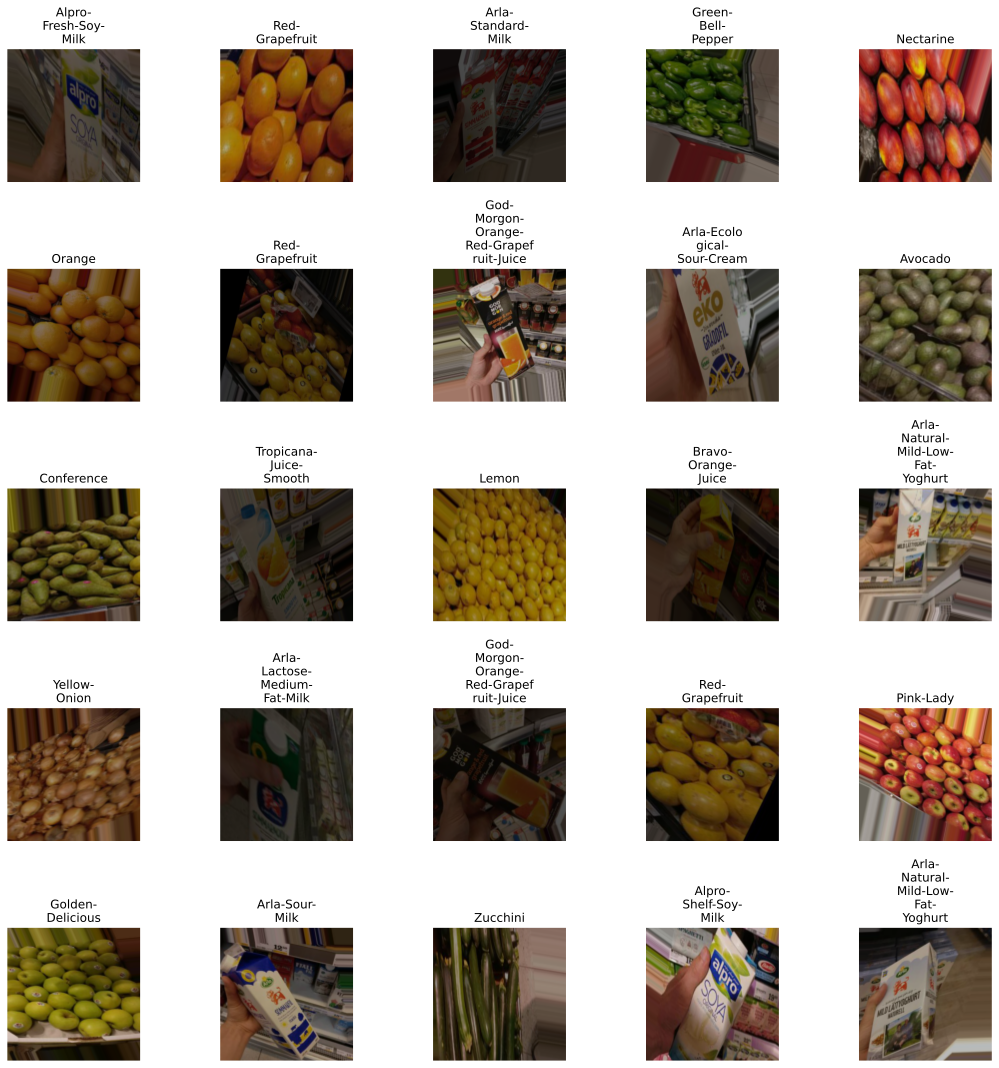

In [15]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=25,  
    zoom_range = 0.5,
    shear_range = 30,
    width_shift_range=0.15,  
    height_shift_range=0.15,
    brightness_range=[0.25,1.0],
    horizontal_flip=False,  
    vertical_flip=False,
    rescale=1. / 255)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

evaluation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=dataset_path, x_col="file_path", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df, directory=dataset_path, x_col="file_path", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

evaluation_generator  = evaluation_datagen.flow_from_dataframe(dataframe=evaluation_df, directory=dataset_path, x_col="file_path", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

class_indices = evaluation_generator.class_indices
class_indices_inverted = {v: k for k, v in class_indices.items()}

x,y = train_generator.next()

fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
num = 0
for i in range(5):
  for j in range (5):
    ax[i,j].imshow(x[num])
    mydict = evaluation_generator.class_indices
    inverted = list(mydict.keys())[list(mydict.values()).index(argmax(y[num]))]
    ax[i,j].set_title("\n".join(wrap(inverted, 10)))
    ax[i,j].axis('off')
    num += 1
  num += 1
        
plt.tight_layout()

#### Save the mapping of the classes into a json file

In [ ]:
indices = train_generator.class_indices
with open('indices.json', 'w') as indices_json:
    json.dump(indices, indices_json)

### Define Callbacks and Metrics

In [ ]:
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('content', 'training', cur_date)
model_filename = 'weights.hdf5'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

callbacks = []
early_stopping = EarlyStopping(
  monitor='val_auc_pr',
  verbose=1, 
  patience=10, 
  mode='max', 
  restore_best_weights=True)

callbacks.append(early_stopping)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard)
model_checkpoint = ModelCheckpoint(model_filename, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch', 
)
callbacks.append(model_checkpoint)

num_classes = len(train_generator.class_indices)

metrics = [CategoricalAccuracy(name='categorical_accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc_pr', curve='PR'),
    AUC(name='auc_roc', curve='ROC'),
    F1Score(name='f1score', num_classes=num_classes), 
    TrueNegatives(name='tn'), 
    TruePositives(name='tp'), 
    FalseNegatives(name='fn'), 
    FalsePositives(name='fp')]

### Define model

#### Create base model with ImageNet weights

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.NASNetLarge(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet',
                                         )
base_model.trainable = False

343613440/343610240 [==============================] - 3s 0us/step


#### Define layers for new classifier

In [ ]:
regularizer = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)
global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.3)
dense = tf.keras.layers.Dense(2048, activation='relu')
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax', activity_regularizer=regularizer)

#### Build the model

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = global_average_pooling_layer(x)
x = dropout_layer(x)
x = dense(x)
y = prediction_layer(x)

model = tf.keras.Model(inputs, y)

In [ ]:
base_learning_rate = 0.00005
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              8259584   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 81)                165969    
Total params: 93,342,371
Trainable params: 8,425,553
Non-trainable params: 84,916,818
__________________________________

### Training

#### Initial training with frozen base model layers to fit the new classifier

In [ ]:
num_epochs = 300

history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator,  callbacks=callbacks)

Epoch 1/300
 1/30 [>.............................] - ETA: 0s - loss: 4.5280 - categorical_accuracy: 0.0078 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc_pr: 0.0110 - auc_roc: 0.4630 - f1score: 6.6733e-04 - tn: 10240.0000 - tp: 0.0000e+00 - fn: 128.0000 - fp: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - ETA: 0s - loss: 4.0222 - categorical_accuracy: 0.1439 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc_pr: 0.0940 - auc_roc: 0.7447 - f1score: 0.0975 - tn: 303520.0000 - tp: 0.0000e+00 - fn: 3794.0000 - fp: 0.0000e+00
Epoch 00001: val_auc_pr improved from -inf to 0.25079, saving model to weights.hdf5
30/30 [==============================] - 150s 5s/step - loss: 4.0222 - categorical_accuracy: 0.1439 - p

#### Save training hisory to a json file

In [ ]:
hist_df = pd.DataFrame(history.history) 

hist_json_file = '/content/history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

### Fine-tuning

#### Definition of callbacks for fine-tuning

In [ ]:
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('content', 'training', cur_date)
model_filename = 'fine_tuning_weights.hdf5'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

callbacks_ft = []
early_stopping_ft = EarlyStopping(
  monitor='val_auc_pr',
  verbose=1, 
  patience=3, 
  mode='max', 
  restore_best_weights=True)

callbacks_ft.append(early_stopping_ft)

tensorboard_ft = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_ft.append(tensorboard_ft)
model_checkpoint_ft = ModelCheckpoint(model_filename, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch', 
)
callbacks_ft.append(model_checkpoint_ft)

#### Recompile model with unfrozen base model layers

In [ ]:
base_model.trainable = True

base_learning_rate = 0.000001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              8259584   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 81)                165969    
Total params: 93,342,371
Trainable params: 93,145,703
Non-trainable params: 196,668
____________________________________

#### Fine-tune the model

In [ ]:
fine_tune_epochs = 15

total_epochs =  history.epoch[-1] + 1 + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator, callbacks=callbacks_ft)

Epoch 1/15
238/238 [==============================] - ETA: 0s - loss: 0.2342 - categorical_accuracy: 0.9141 - precision: 0.9450 - recall: 0.8807 - auc_pr: 0.9744 - auc_roc: 0.9992 - f1score: 0.9172 - tn: 390070.0000 - tp: 4297.0000 - fn: 582.0000 - fp: 250.0000
Epoch 00001: val_auc_pr improved from -inf to 0.95028, saving model to fine_tuning_weights.hdf5
238/238 [==============================] - 414s 2s/step - loss: 0.2342 - categorical_accuracy: 0.9141 - precision: 0.9450 - recall: 0.8807 - auc_pr: 0.9744 - auc_roc: 0.9992 - f1score: 0.9172 - tn: 390070.0000 - tp: 4297.0000 - fn: 582.0000 - fp: 250.0000 - val_loss: 0.3781 - val_categorical_accuracy: 0.8801 - val_precision: 0.9096 - val_recall: 0.8358 - val_auc_pr: 0.9503 - val_auc_roc: 0.9973 - val_f1score: 0.8838 - val_tn: 43315.0000 - val_tp: 453.0000 - val_fn: 89.0000 - val_fp: 45.0000
Epoch 2/15
238/238 [==============================] - ETA: 0s - loss: 0.1912 - categorical_accuracy: 0.9394 - precision: 0.9582 - recall: 0.9244 -

#### Save fine-tuning history to a json file

In [ ]:
hist_ft_df = pd.DataFrame(history_fine.history) 

hist_ft_json_file = '/content/history_fine.json'
with open(hist_ft_json_file, mode='w') as f:
    hist_ft_df.to_json(f)

### Evaluation

In [ ]:
evaluation = model.evaluate(evaluation_generator)

evaluation_data_df = pd.DataFrame(evaluation) 

evaluation_json_file = '/content/evaluation.json'
with open(evaluation_json_file, mode='w') as f:
    evaluation_data_df.to_json(f)

68/68 [==============================] - 21s 313ms/step - loss: 0.1739 - categorical_accuracy: 0.9438 - precision: 0.9542 - recall: 0.9401 - auc_pr: 0.9826 - auc_roc: 0.9975 - f1score: 0.9439 - tn: 86751.0000 - tp: 1020.0000 - fn: 65.0000 - fp: 49.0000


[0.17387253046035767,
 0.9437788128852844,
 0.9541627764701843,
 0.940092146396637,
 0.9825741052627563,
 0.9975166916847229,
 array([0.8695652 , 0.8333333 , 0.90909094, 0.90000004, 0.9677419 ,
        0.9230769 , 0.9       , 0.90909094, 0.9629629 , 0.90909094,
        1.        , 1.        , 0.875     , 1.        , 1.        ,
        1.        , 1.        , 0.9714286 , 1.        , 1.        ,
        1.        , 0.9655172 , 0.969697  , 0.9473684 , 1.        ,
        0.9714286 , 1.        , 1.        , 0.6666667 , 1.        ,
        0.9655172 , 0.9473684 , 0.95238096, 0.85714287, 1.        ,
        0.9473684 , 0.90000004, 0.875     , 0.9142857 , 0.96153843,
        1.        , 1.        , 0.96000004, 1.        , 1.        ,
        0.9142857 , 0.9166667 , 0.9230769 , 0.9629629 , 1.        ,
        0.8965517 , 0.8363637 , 0.8181818 , 1.        , 0.9230769 ,
        0.93333334, 1.        , 0.92      , 0.94117653, 0.8571428 ,
        1.        , 1.        , 0.9743589 , 0.7586207 , 1.

### Save and load model


In [ ]:
model_path =  '/content/drive/My Drive/Colab Notebooks/models/GroceryStoreDataset/NASNetLarge_imagenet_{}.h5'.format(datetime.datetime.now().strftime("%d_%m_%y_%H_%M_%S"))
model.save(model_path) 
model_path

In [ ]:
model = load_model(model_path)

### Plot confusion matrix

In [ ]:
# from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues, file_name='confusion_matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(32,32))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join('/content', file_name) + '.svg')

In [ ]:
def get_image (path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = np.array(img).astype('float64')/255
    x = np.expand_dims(x, axis=0)
    return x

In [ ]:
class_numbers_predicted = []
class_numbers_actual = []

labels_ = evaluation_df.groupby("label")
for label in labels_:
  for path in label[1]["file_path"]:
    x = get_image(os.path.join(dataset_path, path))
    p = model.predict(x)
    predicted = class_indices_inverted[argmax(p)]
    class_numbers_predicted.append(argmax(p))
    actual = label[0]
    class_numbers_actual.append(class_indices[actual])

Confusion matrix, without normalization


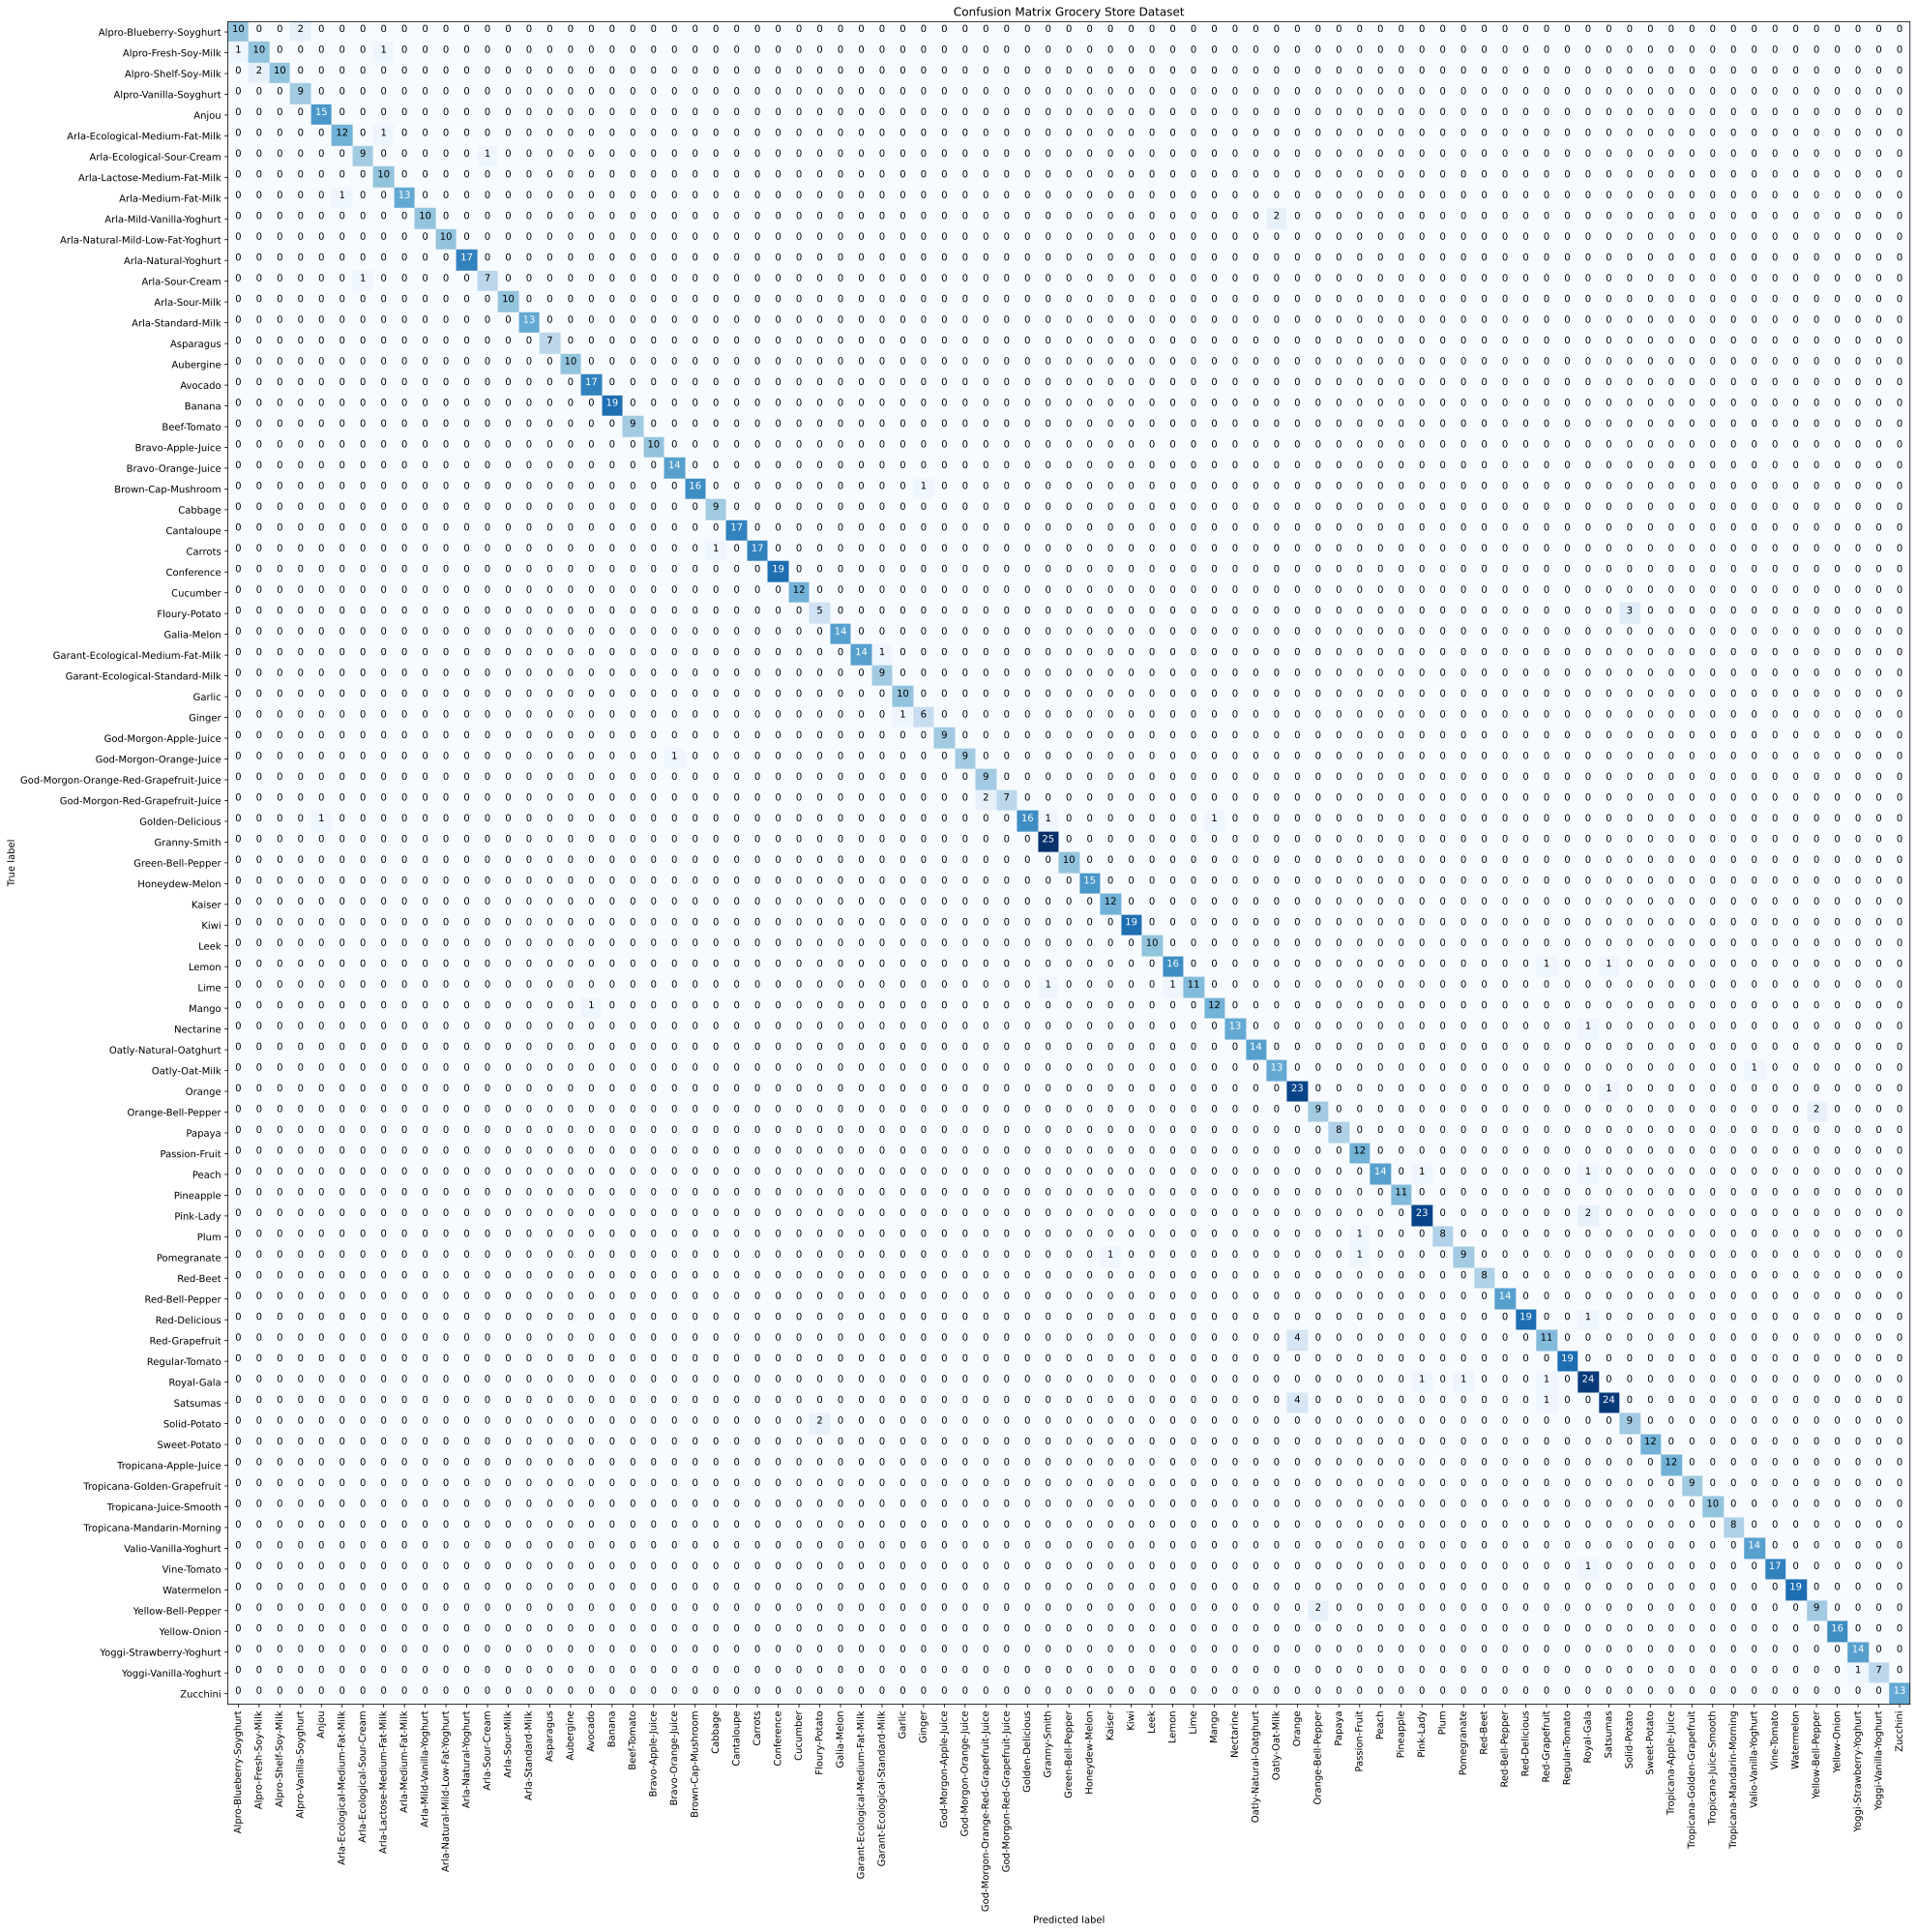

In [ ]:
cm = confusion_matrix(y_true=class_numbers_actual, y_pred=class_numbers_predicted)
cm_plot_labels = evaluation_generator.class_indices
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix Grocery Store Dataset', file_name='confusion_matrix_GroceryStoreDataset')